---

title: pychrome安装和入门
date: 2019-07-10 12:44:03
tags: [pychrome, python, chrome]

---

本篇文章介绍了pychrome的安装和使用, 并且介绍了什么是Chrome DevTools Protocol, 以及pychrome的底层原理。

<!-- more -->

### 安装

- 安装chrome(自行安装不做演示)
- 安装python(我用的是3.6)
- 安装pychrome

In [1]:
!pip install pychrome

  Using cached https://files.pythonhosted.org/packages/2e/9a/ec42df3a2712e70442f4a98cb67c01bdcc3f6be6bd8f25362bec39f85673/pychrome-0.2.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/fa/37/45185cb5abbc30d7257104c434fe0b07e5a195a6847506c074527aa599ec/Click-7.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/29/19/44753eab1fdb50770ac69605527e8859468f3c0fd7dc5a76dd9c4dbd7906/websocket_client-0.56.0-py2.py3-none-any.whl
  Stored in directory: C:\Users\syd\AppData\Local\pip\Cache\wheels\4e\dd\d4\649188092b7b04c320ea3787c9790e95c80b9866308f598fc2
Successfully built pychrome


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## 理解使用Chrome DevTools协议

### DevTools协议介绍

Chrome DevTools协议允许对Chromium，Chrome和其他基于Blink的浏览器进行检测，探测，调试和配置。许多现有项目目前使用该协议。 Chrome的开发者工具就是使用此协议，该团队也负责维护其API。

Chrome浏览器可以远程调试的方式启动, 实际上在浏览器内部启动了一个采用DevTools的服务器, 任何符合该协议的websoket通讯都可以被Chrome响应, pychrome就是基于DevTools封装了接口, 这样你可以向Chrome发送命令, 执行操作, 实现一些自动化浏览器的骚操作。

### 协议基础

当使用`--remote-debugging-port = 0`参数启动Chromium/Chrome时，它启动Chrome DevTools协议服务器并将其WebSocket URL打印到STDERR。输出看起来像这样：

`DevTools listening on ws://127.0.0.1:36775/devtools/browser/a292f96c-7332-4ce8-82a9-7411f3bd280a`

客户端可以创建WebSocket以连接到该URL并开始发送CDP命令。 Chrome DevTools协议主要基于JSONRPC：每个命令都是一个带有id/方法和可选参数的JavaScript结构。

我们可以参考下面的伪代码来了解这个过程:

```js
const ws = new WebSocket(browser.wsEndpoint(), {perMessageDeflate: false});
 ws.send(JSON.stringify({
    id: 1,
    method: 'Target.setDiscoverTargets',
    params: {
      discover: true
    },
  }));
```

此脚本通过DevTools协议发送Targets.setDiscoverTargets命令。浏览器将首先为每个现有目标发出一个Target.targetCreated事件，然后响应该命令：

```
connected!
Sending Target.setDiscoverTargets
{"method":"Target.targetCreated","params":{"targetInfo":{"targetId":"38555cfe-5ef3-44a5-a4e9-024ee6ebde5f","type":"browser","title":"","url":"","attached":true}}}
{"method":"Target.targetCreated","params":{"targetInfo":{"targetId":"52CA0FEA80FB0B98BCDB759E535B21E4","type":"page","title":"","url":"about:blank","attached":false,"browserContextId":"339D5F1CCABEFE8545E15F3C2FA5F505"}}}
{"id":1,"result":{}}
```

一些需要注意的点是:

- 发送到CDP的每个命令都必须具有唯一的“id”参数。消息响应将通过websocket传递，并具有相同的“id”。
- 没有'id'参数的传入WebSocket消息是协议事件。
- 消息顺序在CDP中很重要。在`Target.setDiscoverTargets`的情况下，（隐式）保证在响应之前报告所有当前目标。
- 有一个始终存在的顶级“浏览器”目标。

### Targets & Sessions

Chrome DevTools协议具有与浏览器的许多不同部分进行交互的API  - 例如pages，serviceworkers 和extensions。这些对象都被称为目标(Targets)，可以使用目标域( Target domain)获取/跟踪。

当客户端想要使用CDP与目标进行交互时，必须首先使用Target.attachToTarget命令将其附加到目标。该命令将建立给定目标的会话并返回sessionId。

为了向目标提交CDP命令，每条消息还应包含通常JSONRPC的sessionId参数。

以下示例使用CDP附加到页面(page)并将其跳转到某网站：

(下面的代码都是js代码, 看不懂没关系)

```js
const WebSocket = require('ws');
const puppeteer = require('puppeteer');
const SEND = require('./SEND');

(async () => {
  // Launch a headful browser so that we can see the page navigating.
  const browser = await puppeteer.launch({headless: false});

  // Create a websocket to issue CDP commands.
  const ws = new WebSocket(browser.wsEndpoint(), {perMessageDeflate: false});
  await new Promise(resolve => ws.once('open', resolve));

  // Get list of all targets and find a "page" target.
  const targetsResponse = await SEND(ws, {
    id: 1,
    method: 'Target.getTargets',
  });
  const pageTarget = targetsResponse.result.targetInfos.find(info => info.type === 'page');

  // Attach to the page target.
  const sessionId = (await SEND(ws, {
    id: 2,
    method: 'Target.attachToTarget',
    params: {
      targetId: pageTarget.targetId,
      flatten: true,
    },
  })).result.sessionId;

  // Navigate the page using the session.
  await SEND(ws, {
    sessionId,
    id: 1, // Note that IDs are independent between sessions.
    method: 'Page.navigate',
    params: {
      url: 'https://pptr.dev',
    },
  });
})();
```

### Session Hierarchy

当客户端通过WebSocket连接到启动的Chromium浏览器（sessions.js：10）时，将创建浏览器根会话。如果命令没有指定sessionId（sessions.js：14），则此根会话接收命令。稍后，当根会话用于附加到页面目标（sessions.js：21）时，会创建新的页面会话。

页面会话是从浏览器会话内部创建的，因此是浏览器会话的子节点。当父会话关闭时，例如通过Target.detachFromTarget，它的所有子会话也将关闭。

## pychrome入门

### pychrome原理

pychrome底层使用http协议, 利用python的requests库与chrome浏览器进行通讯, 传输命令。

因为所有的接口都是Chrome DevTools协议提供, 所以pychrome的文档并没有介绍接口, 所以文档很简单, 不了解Chrome DevTools协议的人会很懵逼, 但是打开pychrome的源码看一下, 就知道它仅仅是一个接口的封装。

### 快速入门

为了简单快速了解pychrome的功能, 我们用一个官方例子来演示一下:

#### 第一步启动chrome浏览器

启动浏览器时要确保:

- 所有chrome浏览器已经关闭
- chrome的安装目录已经被加入环境变量Path中

这样你在命令行里输入:`chrome.exe --remote-debugging-port=9222`, 这样就能启动浏览器, 并且开启了调试端口9222。

重新打开一个浏览器, 输入`http://127.0.0.1:9222`, 打开这个网址就应该看到出现一个页面, 并且有几个选项, 但是我们并不关心这个页面, 只是用来证明chrome的server已经正确的启动了。

#### 第二步运行代码

chrome启动以后, 我们可以使用下面的代码来测试:

loading: http://mlln.cn/
loading: https://mlln.cn/
loading: 
loading: https://mlln.cn/
loading: https://mlln.cn/
loading: https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0-alpha.2/css/bootstrap.min.css
loading: https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css
loading: https://cdnjs.cloudflare.com/ajax/libs/featherlight/1.3.5/featherlight.min.css
loading: https://mlln.cn/css/style.css
loading: https://cdn.bootcss.com/jquery/3.2.1/jquery.slim.min.js
loading: https://mlln.cn/js/TweenMax.min.js
loading: https://cdn.bootcss.com/popper.js/1.12.3/umd/popper.min.js
loading: https://cdn.bootcss.com/bootstrap/4.0.0-beta/js/bootstrap.min.js
loading: https://mlln.cn/js/main.js
loading: http://tjs.sjs.sinajs.cn/open/api/js/wb.js
loading: https://mlln.cn/css/oribitron.font.css
loading: https://mlln.cn/css/open.sans.fonts.css
loading: https://mlln.cn/img/bg-pattern.png
loading: https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/fonts/fontawesome-webfont.woff2?v=4.6.3
loading:
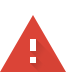

'Target is closing'

In [4]:
import pychrome

# 创建一个浏览器实例
browser = pychrome.Browser(url="http://127.0.0.1:9222")

# 新建一个页签
tab = browser.new_tab()

# 需要注册的回调函数
def request_will_be_sent(**kwargs):
    print("loading: %s" % kwargs.get('request').get('url'))

tab.Network.requestWillBeSent = request_will_be_sent

# 开始接收消息, requestWillBeSent事件发生时被注册的回调函数也可以执行
tab.start()

# 调用方法
tab.Network.enable()

# 调用方法并设置超时时间
tab.Page.navigate(url="http://mlln.cn", _timeout=5)

# 等待页面加载
tab.wait(5)

# 停止处理事件, 停止从chrome接收消息
tab.stop()

# 关闭页签
browser.close_tab(tab)

#### 案例解读

如果你看过pychrome的代码, 你可能知道, pychrome就提供了两个类, `Tab`和`Browser`, 但是我们代码里用到了很多不知名的类`Network`和`Page`, 他们都是Tab的动态属性, 你看Tab类的代码就知道:

```py
    def __getattr__(self, item):
        attr = GenericAttr(item, self)
        setattr(self, item, attr)
        return attr
```

所有Tab的属性都是一个虚拟的GenericAttr, 目的就是做一个标记, 后面发送http/websocket消息的时候可以知道调用的什么接口。 但是具体的Network和Page有什么接口, 你必须去看Chrome DevTools协议, 传送门: https://chromedevtools.github.io/devtools-protocol/tot/

### 换一种写法

我们换一种写法你就更清楚底层在做什么:

```py
import pychrome

browser = pychrome.Browser(url="http://127.0.0.1:9222")
tab = browser.new_tab()

def request_will_be_sent(**kwargs):
    print("loading: %s" % kwargs.get('request').get('url'))


tab.set_listener("Network.requestWillBeSent", request_will_be_sent)

tab.start()
tab.call_method("Network.enable")
tab.call_method("Page.navigate", url="https://github.com/fate0/pychrome", _timeout=5)

tab.wait(5)
tab.stop()

browser.close_tab(tab)
```

比如`tab.call_method("Network.enable")`, 它实际上是给chrome server发送了一个Network.enable的命令。

如果想要看到详细的调试信息, 我们可以开启pychrome的调试模式, 方法是增加环境变量Debug=1

In [ ]:
import os

os.environ['DEBUG'] = '1'

### 案例1: 在页面执行js脚本前注入自己的脚本


Chrome协议地址: https://chromedevtools.github.io/devtools-protocol/tot/Page#method-addScriptToEvaluateOnNewDocument

我们可以使用`addScriptToEvaluateOnNewDocument`接口可以注入脚本, 例如:

In [41]:
print(browser.version())
tab = browser.new_tab()
tab.start()
page = tab.Page
# 必须先调用enable才能注入js
page.enable()
print('在这里注入脚本')
page.addScriptToEvaluateOnNewDocument(source='alert("Hello")')

page.navigate(url="http://jupyter.cn", _timeout=5)

tab.wait(5)

tab.stop()

# 关闭页签
browser.close_tab(tab)

{'Browser': 'Chrome/75.0.3770.100', 'Protocol-Version': '1.3', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36', 'V8-Version': '7.5.288.23', 'WebKit-Version': '537.36 (@cd0b15c8b6a4e70c44e27f35c37a4029bad3e3b0)', 'webSocketDebuggerUrl': 'ws://127.0.0.1:9222/devtools/browser/8c5e5a30-eae9-46e9-96f5-b6a7d0d8a2f8'}
SEND > {"method": "Page.enable", "params": {}, "id": 1001}
< RECV {"id":1001,"result":{}}
在这里注入脚本
SEND > {"method": "Page.addScriptToEvaluateOnNewDocument", "params": {"source": "alert(\"Hello\")"}, "id": 1002}
< RECV {"id":1002,"result":{"identifier":"1"}}
SEND > {"method": "Page.navigate", "params": {"url": "http://jupyter.cn"}, "id": 1003}
< RECV {"id":1003,"result":{"frameId":"4A9EB5115C1CD7D26F34D46682FADDD6","loaderId":"87BF33C1476328B4FE34C6C52F4609D4"}}
< RECV {"method":"Page.frameStartedLoading","params":{"frameId":"4A9EB5115C1CD7D26F34D46682FADDD6"}}
< RECV {"method":"Page.frameNavigate

'Target is closing'

### 案例2: 管理多个标签页


```py
import time
import pychrome


class EventHandler(object):
    def __init__(self, browser, tab):
        self.browser = browser
        self.tab = tab
        self.start_frame = None
        self.is_first_request = True
        self.html_content = None

    def frame_started_loading(self, frameId):
        if not self.start_frame:
            self.start_frame = frameId

    def request_intercepted(self, interceptionId, request, **kwargs):
        if self.is_first_request:
            self.is_first_request = False
            headers = request.get('headers', {})
            headers['Test-key'] = 'test-value'
            self.tab.Network.continueInterceptedRequest(
                interceptionId=interceptionId,
                headers=headers,
                method='POST',
                postData="hello post data: %s" % time.time()
            )
        else:
            self.tab.Network.continueInterceptedRequest(
                interceptionId=interceptionId
            )

    def frame_stopped_loading(self, frameId):
        if self.start_frame == frameId:
            self.tab.Page.stopLoading()
            result = self.tab.Runtime.evaluate(expression="document.documentElement.outerHTML")
            self.html_content = result.get('result', {}).get('value', "")
            print(self.html_content)
            self.tab.stop()


def close_all_tabs(browser):
    if len(browser.list_tab()) == 0:
        return

    for tab in browser.list_tab():
        try:
            tab.stop()
        except pychrome.RuntimeException:
            pass

        browser.close_tab(tab)

    time.sleep(1)
    assert len(browser.list_tab()) == 0


def main():
    browser = pychrome.Browser()

    close_all_tabs(browser)

    tabs = []
    for i in range(4):
        tabs.append(browser.new_tab())

    for i, tab in enumerate(tabs):
        eh = EventHandler(browser, tab)
        tab.Network.requestIntercepted = eh.request_intercepted
        tab.Page.frameStartedLoading = eh.frame_started_loading
        tab.Page.frameStoppedLoading = eh.frame_stopped_loading

        tab.start()
        tab.Page.stopLoading()
        tab.Page.enable()
        tab.Network.setRequestInterceptionEnabled(enabled=True)
        tab.Page.navigate(url="http://httpbin.org/post")

    for tab in tabs:
        tab.wait(60)
        tab.stop()
        browser.close_tab(tab)

    print('Done')


if __name__ == '__main__':
    main()
```

### 案例3: 发送post

```py
import pychrome
import time
import urllib



class ChromiumClient(object):
    """ Client to interact with Chromium """

    def __init__(self):
        self.browser = pychrome.Browser(url="http://127.0.0.1:9222")

    def do_post(self):
        self.tab = self.browser.new_tab()

        event_handler = EventHandler()

        event_handler.set_token('asdkflj497564dsklf')
        event_handler.set_post_data({
            'param1': 'value1',
            'param2': 'value2'
        })

        url_pattern_object = {'urlPattern': '*fate0*'}
        self.tab.Network.setRequestInterception(patterns=[url_pattern_object])

        self.tab.Network.requestIntercepted = event_handler.on_request_intercepted

        self.tab.start()

        self.tab.Network.enable()
        self.tab.Page.enable()

        self.tab.Page.navigate(url='https://github.com/fate0/pychrome')

        self.tab.wait(5)
        self.tab.stop()

        self.browser.close_tab(self.tab.id)


class EventHandler(object):
    def __init__(self):
        self.tab = None
        self.token = None
        self.is_first_request = False
        self.post_data = {}

    def set_tab(self, t):
        self.tab = t

    def set_token(self, t):
        self.token = t

    def set_post_data(self, pd):
        self.post_data = pd

    def on_request_intercepted(self, **kwargs):
        new_args = {'interceptionId': kwargs['interceptionId']}

        if self.is_first_request:
            # Modify first request only, following are media/static
            # requests...
            self.is_first_request = False

            extra_headers = {
                'Requested-by': 'Chromium',
                'Authorization': 'Token ' + self.token
            }

            request = kwargs.get('request')
            request['headers'].update(extra_headers)

            new_args.update({
                'url': request['url'],
                'method': 'POST',
                'headers': request['headers'],
                'postData': urllib.urlencode(self.post_data)
            })

        self.tab.Network.continueInterceptedRequest(**new_args)


if __name__ == '__main__':
    client = ChromiumClient()

    client.do_post()
```

## 总结

pychrome其实是一个简单的api的封装, 半天时间你就能看完代码。 这样好处是你可以自己改源码的难度很低, 而且你可以自己查看Chrome协议来定制代码, 如果你想要使用pychrome, 那么你会发现它几乎没有文档, 你需要看谷歌官方的Chrome DevTools Protocol来辅助自己的开发。

所以你最重要的文档在这里:

- https://chromedevtools.github.io/devtools-protocol/tot/
- https://github.com/cyrus-and/chrome-remote-interface/